In [87]:
import pandas as pd

In [88]:
datambg = pd.read_csv("datalabel/mbglabel.csv")

In [89]:
datasarc = pd.read_csv("datalabel/sarcasticlabel.csv")

In [90]:
datatrainmix = pd.concat([datambg, datasarc], ignore_index=True)

In [91]:
datatrainmix.head()

,steming_data,Sentiment
0,makan siang gratis mending,Positif
1,bela mbak bias sekolah makan siang gratis pas ...,Positif
2,anggar dituruninnya ngopernya blog ya dicicipi...,Positif
3,karyawan industri cikarang makan siang jemput ...,Positif
4,ambil abang ya makan siang gratis ya abang rol...,Positif


## ***Bidirectional LSTM***

In [92]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM, Bidirectional, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [93]:
X = datatrainmix['steming_data']
X

0                              makan siang gratis mending
1       bela mbak bias sekolah makan siang gratis pas ...
2       anggar dituruninnya ngopernya blog ya dicicipi...
3       karyawan industri cikarang makan siang jemput ...
4       ambil abang ya makan siang gratis ya abang rol...
                              ...                        
9835    hasil itjima ulama agama nihil orang username ...
9836    ciyee tani bawang nih ya sandiwara fazdlizonk ...
9837    username wuih capres keren pakai jas besok pil...
9838    username welcome indonesia sedih banget adaaa ...
9839       terimakasih kasih libur gratis hashtag hashtag
Name: steming_data, Length: 9840, dtype: object

In [94]:
categories = datatrainmix['Sentiment'].unique().tolist()
categories

['Positif', 'Negatif', 'Netral']

In [95]:
# Create a mapping dictionary
category_to_number = {category: index for index, category in enumerate(categories)}
# Assuming 'data' is your DataFrame and 'category' is the column
datatrainmix['numbered_category'] = datatrainmix['Sentiment'].map(category_to_number)

In [96]:
y = datatrainmix['numbered_category']
y_one_hot = to_categorical(y, num_classes=3)
y_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=5)

In [98]:
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(X_train)

In [99]:
vocab_size = len(tokenizer.word_index)+1

In [100]:
max_length = datatrainmix['steming_data'].apply(len).max()
max_length

247

In [101]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_train_pad.shape

(7872, 247)

In [102]:
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_val_pad.shape

(1968, 247)

In [103]:
import tensorflow as tf
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [104]:
# Define the model
model = Sequential([
    Input(shape=(max_length,) ),
    # Embedding layer with input_dim (vocab size) and output_dim (embedding size)
    Embedding(input_dim=vocab_size, output_dim=16),  # 1500 words, 8-dimensional vectors

    # Bidirectional LSTM layer (LSTM layer wrapped in Bidirectional for better context)
    Bidirectional(LSTM(32, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)),
    #Bidirectional(LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),

    # Dropout layer to prevent overfitting
    Dropout(0.5),  # 50% dropout rate

    # Dense layer with L2 regularization
    #Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    # Dense layer with L2 regularization
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),

    # # Dropout to further regularize the model
    # Dropout(0.5),  # 50% dropout rate

    # Output layer for binary classification (1 output neuron)
    Dense(3, activation='softmax')  
])

In [105]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy', F1Score()])

In [106]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 247, 16)        │       191,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,643 (799.39 KB)

 Trainable params: 204,643 (799.39 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Anda perlu mendapatkan label dalam bentuk angka (bukan one-hot) untuk menghitung bobot
# Ambil dari kolom 'numbered_category' yang sudah Anda buat sebelumnya
y_integers = datatrainmix['numbered_category'].values

# Hitung bobot kelas
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Ubah menjadi format dictionary yang bisa dibaca Keras
class_weight_dict = dict(enumerate(class_weights))

print("Class Weight Dictionary:", class_weight_dict)

Class Weight Dictionary: {0: 0.5199746353836399, 1: 1.550094517958412, 2: 2.3163841807909606}


In [108]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=5e-4)

# Train the model and store the history
history = model.fit(
    X_train_pad, y_train,  # Training data
    validation_data=(X_val_pad, y_val),  # Validation data
    epochs=25, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - categorical_accuracy: 0.3631 - f1_score: 0.0175 - loss: 1.2514 - val_categorical_accuracy: 0.6458 - val_f1_score: 0.0030 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 2/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - categorical_accuracy: 0.5721 - f1_score: 0.2504 - loss: 1.0126 - val_categorical_accuracy: 0.7556 - val_f1_score: 0.7269 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 3/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - categorical_accuracy: 0.7257 - f1_score: 0.6913 - loss: 0.7637 - val_categorical_accuracy: 0.7952 - val_f1_score: 0.7869 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 4/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - categorical_accuracy: 0.7618 - f1_score: 0.7534 - loss: 0.6537 - val_categorical_accuracy: 0.7856 - val_f1_score: 0.7817 - val_loss: 0.6160 - learning_rate: 0.0010
Epoch 5/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - categorical_accuracy: 0.7975 - f1_score: 0.7958 - loss: 0.5656 -

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val_pad)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = ['Negatif', 'Netral', 'Positif']
labels_ordered = [1, 2, 0]

# Cetak Laporan Klasifikasi
print("Laporan Klasifikasi Bidirectional LSTM:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=labels_ordered))

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Laporan Klasifikasi Bidirectional LSTM:

              precision    recall  f1-score   support

     Negatif       0.85      0.78      0.81       418
      Netral       0.41      0.66      0.51       266
     Positif       0.93      0.85      0.89      1284

    accuracy                           0.80      1968
   macro avg       0.73      0.76      0.74      1968
weighted avg       0.85      0.80      0.82      1968



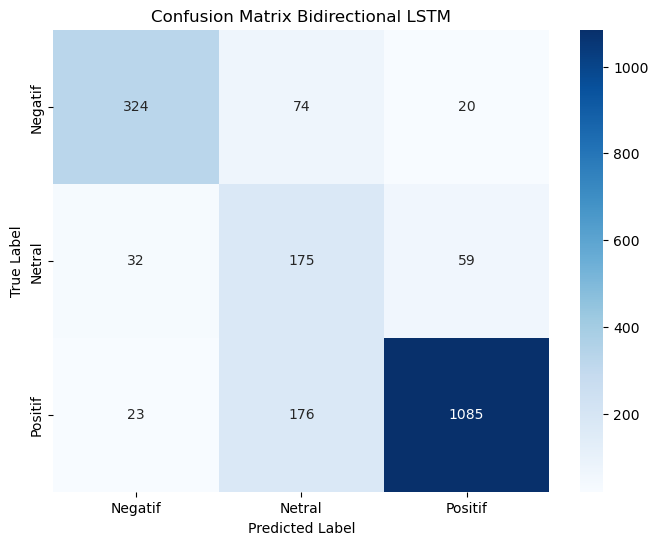

In [110]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_ordered)

# Tampilkan heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

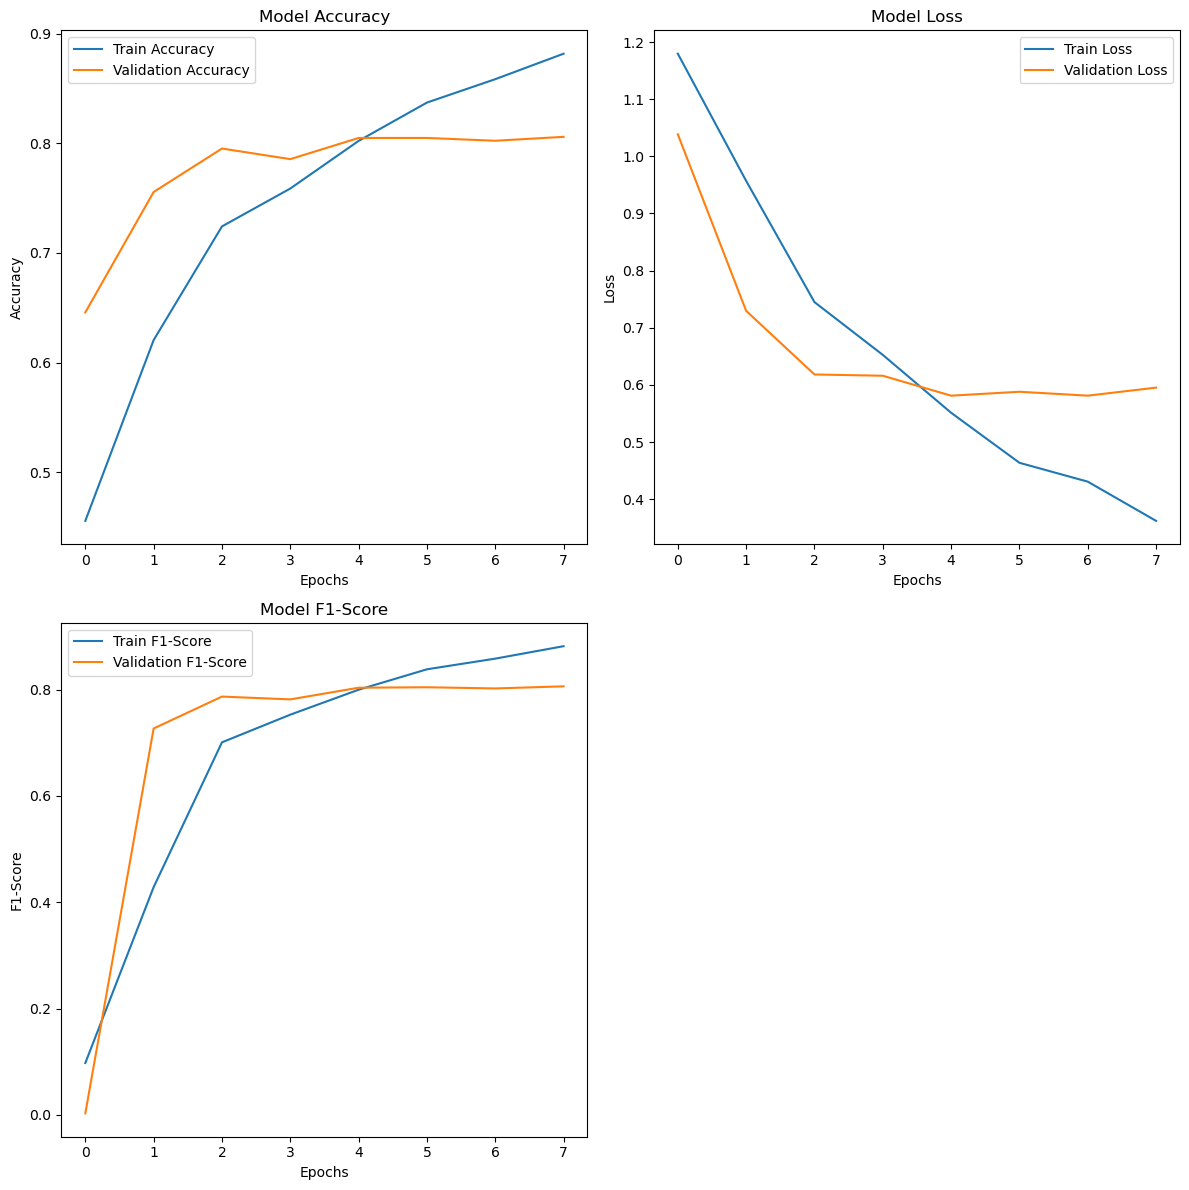

In [111]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(12, 12))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot F1-Score
plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [112]:
# Save the model in SavedModel format
model.save('bidirectional_lstm/bidirectional_lstm_model.h5')

In [113]:
import json
# Save the word index
with open('bidirectional_lstm/word_index.json', 'w') as file:
    json.dump(tokenizer.word_index, file)

## ***Test***

In [114]:
df = pd.read_csv('datalabel/mbglabel.csv')

In [119]:
with open('bidirectional_lstm/word_index.json', 'r', encoding='utf-8') as f:
    word_index = json.load(f)

def tokenize_tweet(steming_data):
    words = steming_data.split(' ')
    tokenized_tweet = [word_index.get(word, 0) for word in words]
    return tokenized_tweet

# Tokenize each complaint
df['tokenized_tweet'] = df['steming_data'].apply(tokenize_tweet)

In [120]:
X = df['steming_data']

In [121]:
X_train_seq = tokenizer.texts_to_sequences(X)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [122]:
y = model.predict(X_train_pad)

287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [123]:
indices = np.where(y >= 0.5)[0]
indices

array([   0,    1,    2, ..., 9166, 9167, 9168], dtype=int64)

In [124]:
filtered_df = df.iloc[indices]
filtered_df

,steming_data,Sentiment,tokenized_tweet
0,makan siang gratis mending,Positif,"[1, 3, 2, 38]"
1,bela mbak bias sekolah makan siang gratis pas ...,Positif,"[286, 94, 2119, 8, 1, 3, 2, 80, 240, 1255, 19,..."
2,anggar dituruninnya ngopernya blog ya dicicipi...,Positif,"[24, 6346, 6347, 3906, 5, 6348, 9, 1, 3, 2]"
3,karyawan industri cikarang makan siang jemput ...,Positif,"[1051, 2095, 4038, 1, 3, 3352, 185, 2223, 660,..."
4,ambil abang ya makan siang gratis ya abang rol...,Positif,"[130, 170, 5, 1, 3, 2, 5, 170, 7497, 7498]"
...,...,...,...
9164,usaha pulih sebentar program makan siang grati...,Netral,"[247, 2232, 2233, 4, 1, 3, 2, 1088]"
9165,status program makan siang gratis sumber dana ...,Negatif,"[1324, 4, 1, 3, 2, 273, 18, 129, 129, 148, 175..."
9166,pemkab bima tunggu teknik program makan siang ...,Netral,"[2831, 11902, 210, 4629, 4, 1, 3, 2]"
9167,program makan siang gizi gratis sumbar januari,Positif,"[4, 1, 3, 6, 2, 3599, 803]"


In [125]:
filtered_df.to_csv('pusingsay.csv', index=False)